In [125]:
# do required imports
import difflib
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick
import matplotlib as matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [126]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [127]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

In [128]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )
    return  [{word : get_prob(word)} for word in check_words]

In [129]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'and not the', 'without']



In [130]:
def calculate_error_rate(sentences):
    result = calculate_errors(sentences)
    #print(result)
    return 1- sum(result)/len(result)
    
def calculate_errors(sentences):
    return [1 if is_correct_prediction(s[0], s[1], s[2]) else 0 for s in sentences]

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    words,preds = zip(*list(map(lambda x: list(x.items())[0],predictions)))
    predicted_word = words[np.argmax(preds)]
    return predicted_word == correct_word

In [131]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_no_attractors(num_sentences, num_words, NN, NNS, VBP, VBZ):
    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices_x = []
    indices_u = []
    for i in range(num_sentences):
        while True:
            x,y = np.random.randint(num_words, size=2)
            if (x,y) not in indices_x:
                indices_x.append((x,y))
                break
        while True:
            u,v = np.random.randint(num_words, size=2)
            if (u,v) not in indices_u:
                indices_u.append((u,v))
                break
        sentences_si.append((f"the {NN[x]}", [VBP[y], VBZ[y]], VBZ[y],))
        sentences_pl.append((f"the {NNS[u]}", [VBP[v], VBZ[v]], VBP[v],))
    return sentences_si, sentences_pl

def gen_one_attractor(num_sentences, num_words, same, NN, NNS, VBP, VBZ, 
                      template = "the {} of the {}", first_dep = True):

    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices = []
    for i in range(num_sentences):
        while True:
            x,y,z = np.random.randint(num_words, size=3)
            if (x,y,z) not in indices:
                indices.append((x,y,z))
                break
        if(same):
            sentences_si.append((template.format(NN[x], NN[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NNS[x], NNS[z]), [VBP[y], VBZ[y]], VBP[y],))
        elif first_dep:
            sentences_si.append((template.format(NN[x], NNS[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NNS[x], NN[z]), [VBP[y], VBZ[y]], VBP[y],))
        else:
            sentences_si.append((template.format(NNS[x], NN[z]), [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((template.format(NN[x], NNS[z]), [VBP[y], VBZ[y]], VBP[y],))
    return sentences_si, sentences_pl

num_sentences = 1000
num_words = len(NN)



In [132]:
templates = [
    "the {} in the {}", # attractor
    "the {} by the {}", # attractor
    "the {} of the {}", # attractor
    "the {} near the {}", # attractor
    "the {} at the {}", # attractor
    "the {} without the {}", # attractor
    "the {} the {}", 
    "the {} that the {}",
    "the {} whether the {}",
]

In [133]:
num_sentences = 1000

results = {}
for t in templates:
    np.random.seed(100) #generate from same verbs and nouns for each template
    print (t)
    si, pl = gen_one_attractor(
        num_sentences, 
        num_words, 
        False, 
        NN, 
        NNS, 
        VBP, 
        VBZ, 
        template = t, 
        first_dep = True)
    si_most_recent_noun_rate = calculate_error_rate(si)
    pl_most_recent_noun_rate = calculate_error_rate(pl)
    most_recent_noun_rate = 0.5*(pl_most_recent_noun_rate + si_most_recent_noun_rate)
    results[t] = most_recent_noun_rate


print (results)

the {} in the {}
the {} by the {}
the {} of the {}
the {} near the {}
the {} at the {}
the {} without the {}
the {} the {}
the {} that the {}
the {} whether the {}
{'the {} in the {}': 0.5895, 'the {} by the {}': 0.687, 'the {} of the {}': 0.6125, 'the {} near the {}': 0.6275, 'the {} at the {}': 0.704, 'the {} without the {}': 0.6719999999999999, 'the {} the {}': 0.7815, 'the {} that the {}': 0.788, 'the {} whether the {}': 0.8520000000000001}


In [134]:
conj_template = "the {} and the {}"

np.random.seed(100) #generate from same verbs and nouns for each template

si_conj, _ = gen_one_attractor(
    num_sentences, 
    num_words, 
    True, 
    NN, 
    NNS, 
    VBP, 
    VBZ, 
    template = conj_template)

si_conj_last_noun_rate = 1 - calculate_error_rate(si_conj) #error means plural prediction which is actually good 


In [135]:
singular_template = "the {} 's {}"
plural_template = "the {} ' {}"
possessive_template = f"{singular_template} ({plural_template})"

np.random.seed(100) #generate from same verbs and nouns for each template

si_possesive, _ = gen_one_attractor(
    num_sentences, 
    num_words, 
    False, 
    NN, 
    NNS, 
    VBP, 
    VBZ, 
    template = singular_template, first_dep=True)

np.random.seed(100) #generate from same verbs and nouns for each template

_, pl_possesive = gen_one_attractor(
    num_sentences, 
    num_words, 
    False, 
    NN, 
    NNS, 
    VBP, 
    VBZ, 
    template = plural_template, first_dep=True)

si_possessive_success_rate = calculate_error_rate(si_possesive)
pl_possessive_success_rate = calculate_error_rate(pl_possesive)
possessive_last_noun_rate = 0.5*(si_possessive_success_rate + pl_possessive_success_rate)

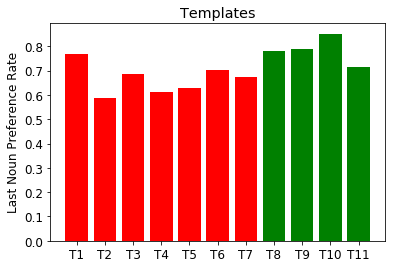

In [136]:
all_templates = [conj_template] + templates + [possessive_template]
template_names = [f"T{i + 1}" for i in range(0, len(all_templates))]
last_noun_rates = [si_conj_last_noun_rate] + list(results.values()) + [possessive_last_noun_rate]
y_pos = np.arange(len(all_templates))
plt.bar(y_pos, last_noun_rates, align='center', color=['r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'g', 'g', 'g'])
plt.xticks(y_pos, template_names)
plt.ylabel('Last Noun Preference Rate')
plt.title('Templates')
 
plt.show()

In [137]:
all_templates

['the {} and the {}',
 'the {} in the {}',
 'the {} by the {}',
 'the {} of the {}',
 'the {} near the {}',
 'the {} at the {}',
 'the {} without the {}',
 'the {} the {}',
 'the {} that the {}',
 'the {} whether the {}',
 "the {} 's {} (the {} ' {})"]

In [138]:
si_possessive_success_rate

0.774

In [139]:
pl_possessive_success_rate

0.656

In [140]:
x_template = "the {} {}"

np.random.seed(100) #generate from same verbs and nouns for each template


si_x, pl_x = gen_one_attractor(
    num_sentences, 
    num_words, 
    False, 
    NN, 
    NNS, 
    VBP, 
    VBZ, 
    template = x_template, first_dep=True)

pl_x_success_rate = calculate_error_rate(pl_x)
si_x_success_rate = calculate_error_rate(si_x)


In [141]:
pl_x_success_rate

0.633

In [142]:
si_x_success_rate

0.712

In [148]:
for r in last_noun_rates:
    print ("%.2f" % r)

0.77
0.59
0.69
0.61
0.63
0.70
0.67
0.78
0.79
0.85
0.72
